# The Input Section

You only need to change ``global_n``

In [1]:
global_n = 3

length = global_n^2 - global_n
xvars = [var('x%s%s'%(i,j)) for i in range(1,global_n+1) for j in range(1,global_n+1) if not i==j]
xvars

[x12, x13, x21, x23, x31, x32]

# Preamble: A lot of functions.

In [2]:
def symbols_to_vector(symbolic_expression):
    string = str(symbolic_expression)
    vec = [0]*(length + 1)

    if string == "0":
        return vector(vec)

    sign = 1
    factor = 1
    variable = 1

    symbols_vec = [0]+xvars 

    terms =  string.replace('-',' - ').split()
    for term in terms:
        letters = term.split("*")
        if len(letters) == 1: #term is either of the form '+' or '-' or a variable or constant
            letter = letters[0]
            if letter in ["+"]:
                sign = 1
            elif letter in ["-"]:
                sign = -1
            elif letter.isdigit():
                vec[0] = sign*int(letter)
                factor = 1
                sign = 1
            elif var(letter) in symbols_vec:
                index = symbols_vec.index(var(letter))
                vec[index] = factor*sign
                factor = 1
                sign = 1
        else: #term is of the form factor*variable or -variable
            for letter in letters:
                if letter.isdigit():
                    factor = int(letter)
                elif var(letter) in symbols_vec:
                    index = symbols_vec.index(var(letter))
                    vec[index] = factor*sign
                    factor = 1
                    sign = 1
    return vector(vec)

def vector_to_symbols(vec):
        symbols_vec = vector([0]+xvars) #TODO
        return symbols_vec.dot_product(vector(vec))

class Expression:
    
    def __init__(self, coordinates, assumptions):
        self.assumptions = assumptions
        self.coordinates = vector(coordinates)
        
    def is_valid_strict(self):
        #checks if a strict inequality (question) is satified under the assumptions of other strict inequalities
        #this is not satisfied if intP interected with H_c is nonempty
        P = Polyhedron(ieqs = self.assumptions)
        #complement of halfspace defined by strict inequality in question
        H_c = Polyhedron(ieqs = [[-i for i in self.coordinates]]) 
        if len(H_c.intersection(P).vertices())==0:
            return true
        else:
            for F in P.faces(P.dimension()-1):
                if H_c.intersection(F.as_polyhedron()) == H_c.intersection(P):
                    return true
        return false
    
    def is_valid_nonstrict(self):
        #checks if a non-strict inequality (question) is satified under the assumptions of other strict inequalities
        #this is satisfied if intP is contained in H. H is closed, so this is equivalent to P contianed in H
        P = Polyhedron(ieqs = self.assumptions)
        H = Polyhedron(ieqs = [self.coordinates]) 
        if H.intersection(P)==P:
            return true
        else:     
            return false

    def  __gt__(self, other):
        #definition of >
        #return self.is_valid_strict(assumptions, self.coordinates - other.coordinates)
        return Expression(coordinates = self.coordinates - other.coordinates, assumptions = self.assumptions).is_valid_strict()
    
    def __lt__(self,other):
        #definition of <
        return Expression(coordinates = other.coordinates - self.coordinates, assumptions = self.assumptions).is_valid_strict()
    
    def __eq__(self, other):
        #definition of ==
        if Expression(coordinates = self.coordinates - other.coordinates, assumptions = self.assumptions).is_valid_nonstrict() and Expression(coordinates = other.coordinates - self.coordinates, assumptions = self.assumptions).is_valid_nonstrict(): 
            return true
        else:
            return false
    
    def __le__(self, other):
        #definition of <=
        return (self<other or self==other)
    
    def __ge__(self, other):
        #definition of >=
        return (self>other or self==other)
    
    def __add__(self,other):
        #definition of +
        return Expression(coordinates = self.coordinates + other.coordinates, assumptions = self.assumptions)
    
    def __sub__(self,other):
        #definition of -
        return Expression(coordinates = self.coordinates - other.coordinates, assumptions = self.assumptions)
    
    def is_comparable_to(self, other):
        if self>= other or self <= other:
            return true
        else:
            return false
        
    def as_symbols(self):
        symbols_vec = vector([0]+xvars)
        return symbols_vec.dot_product(vector(self.coordinates))
    


def minimum(expr1, expr2):
    if expr1 <= expr2:
        return expr1
    elif expr2 <= expr1:
        return expr2
    else:
        print("cannot decide minimum of "+str(expr1)+" and "+str(expr2))

def intersect_trop_lines(assumptions, first,second):
    #translate symbolic expressions into vectors
    a_ex = Expression(assumptions = assumptions, coordinates = symbols_to_vector(first[0]))
    b_ex = Expression(assumptions = assumptions, coordinates = symbols_to_vector(first[1]))
    c_ex = Expression(assumptions = assumptions, coordinates = symbols_to_vector(second[0]))
    d_ex = Expression(assumptions = assumptions, coordinates = symbols_to_vector(second[1]))
    res = []
    if c_ex>a_ex and d_ex>b_ex and c_ex-a_ex<d_ex-b_ex: #region 1
        res = [c_ex, b_ex - a_ex + c_ex]
    #elif c_ex>a_ex and d_ex>b_ex and c_ex-a_ex==d_ex-b_ex: #region 1 intersected 2
    #    return []
    elif c_ex>a_ex and d_ex>b_ex and c_ex-a_ex>d_ex-b_ex: #region 2
        res = [a_ex - b_ex + d_ex, d_ex]
    #elif c_ex>a_ex and d_ex==b_ex and c_ex-a_ex>d_ex-b_ex: #region 2 intersected 3
    #    return []
    elif c_ex>a_ex and d_ex<b_ex and c_ex-a_ex>d_ex-b_ex: #region 3
        res = [a_ex, d_ex]
    #elif c_ex==a_ex and d_ex<b_ex and c_ex-a_ex>d_ex-b_ex: #region 3 intersected 4
    #    return []
    elif c_ex<a_ex and d_ex<b_ex and c_ex-a_ex>d_ex-b_ex: #region 4
        res = [a_ex, a_ex - c_ex + d_ex]
    #elif c_ex<a_ex and d_ex<b_ex and c_ex-a_ex==d_ex-b_ex: #region 4 intersected 5
    #    return []   
    elif c_ex<a_ex and d_ex<b_ex and c_ex-a_ex<d_ex-b_ex: #region 5
        res = [b_ex + c_ex - d_ex, b_ex]
    #elif c_ex<a_ex and d_ex==b_ex and c_ex-a_ex<d_ex-b_ex: #region 5 intersected 6
    #    return []
    elif c_ex<a_ex and d_ex>b_ex and c_ex-a_ex<d_ex-b_ex: #region 6
        res = [c_ex, b_ex]
    #elif c_ex==a_ex and d_ex>b_ex and c_ex-a_ex<d_ex-b_ex: #region 6 intersected 1
    #    return []
    
    elif a_ex>c_ex and b_ex>d_ex and a_ex-c_ex<b_ex-d_ex: #region 1
        res = [a_ex, d_ex - c_ex + a_ex]
    elif a_ex>c_ex and b_ex>d_ex and a_ex-c_ex>b_ex-d_ex: #region 2
        res = [c_ex - d_ex + b_ex, b_ex]
    elif a_ex>c_ex and b_ex<d_ex and a_ex-c_ex>b_ex-d_ex: #region 3
        res = [c_ex, b_ex]
    elif a_ex<c_ex and b_ex<d_ex and a_ex-c_ex>b_ex-d_ex: #region 4
        res = [c_ex, c_ex - a_ex + b_ex]  
    elif a_ex<c_ex and b_ex<d_ex and a_ex-c_ex<b_ex-d_ex: #region 5
        res = [d_ex + a_ex - b_ex, d_ex]
    elif a_ex<c_ex and b_ex>d_ex and a_ex-c_ex<b_ex-d_ex: #region 6
        res = [a_ex, d_ex]

    if len(res):
        return [el.as_symbols() for el in res]

    
class polytron:
    def __init__(self, assumptions, vertices):
        self.assumptions = assumptions
        self.vertices = vertices
        self.pseudovertices = self.get_pseudo_and_edges(assumptions, self.vertices)[0]
        self.edges = self.get_pseudo_and_edges(assumptions, vertices)[1]
        
    def get_pseudo_and_edges(self, assumptions, vertices):
        pseudovertices = copy(vertices)
        edges = []
        for pair in Subsets(range(len(vertices)),2):
            intersection = intersect_trop_lines(assumptions, vertices[pair[0]],vertices[pair[1]])
            if intersection:
                pseudovertices.append(intersection)
                index = len(pseudovertices)-1
                edges.append([pair[0],index])
                edges.append([pair[1],index])
            else:
                edges.append(list(pair))
        return [pseudovertices, edges]


def tangent_cone(polytron, vertex_index):
    
    def primitive_vector_in_edge_direction(assumptions, direction):
        x = Expression(assumptions = assumptions, coordinates = symbols_to_vector(direction[0]))
        y = Expression(assumptions = assumptions, coordinates = symbols_to_vector(direction[1]))
        x_negative = Expression(assumptions = assumptions, coordinates = [-i for i in x.coordinates])
        y_negative = Expression(assumptions = assumptions, coordinates = [-i for i in y.coordinates])
        zero = Expression(assumptions = assumptions, coordinates = symbols_to_vector(0))
        
        if x==zero and y>zero:
            primitive = [ 0, 1]
        elif x==zero and y<zero:
            primitive = [ 0,-1]
        elif x>zero and y>zero:
            primitive = [ 1, 1]
        elif x>zero and y==zero:
            primitive = [ 1, 0]
        elif x<zero and y==zero:
            primitive = [-1, 0]
        elif x<zero and y<zero:
            primitive = [-1,-1]
        else:
            print 'cannot find primitive vector in direction ('+str(x.coordinates)+' , '+str(y.coordinates)+') under assumptions '+str(x.assumptions)
        return primitive
    
    ##compute the generating function of the tangent cone at the given vertex
    vertex = polytron.pseudovertices[vertex_index]
    
    
    #find neighbours of vertex
    incident_edges_index = [edge for edge in polytron.edges if vertex_index in edge]
    neighbours_index = []
    for edge_index in incident_edges_index:
        for index in edge_index:
            if index==vertex_index:
                continue
            else:
                neighbours_index.append(index)    
    neighbours = [ polytron.pseudovertices[index] for index in neighbours_index ]
    
    #compute edge-directions
    edge_directions = [ [neighbour[0]-vertex[0],neighbour[1]-vertex[1]] for neighbour in neighbours ]
    
    primitives=[]
    #find primitive vector in edge-direction
    for direction in edge_directions:
        primitives.append(primitive_vector_in_edge_direction(polytron.assumptions, direction))
    
    
    t1, t2, n = var('t1, t2, n')
    return ( t1^(n*vertex[0])* t2^(n*vertex[1]) )  / ( (1 - t1^primitives[0][0] * t2^primitives[0][1]) * (1 - t1^primitives[1][0] * t2^primitives[1][1])  )


# Constructing the Kleene fan

Making the Polyhedral Subdivision of $\mathbb R^d$  for 6 variables

The Setup: 

In [3]:
def create_incidence_matrix(size):
    return matrix([[var('x%s%s'%(i,j)) if not i==j else 0 for j in range(1,size+1) ] for i in range(1,size+1)])

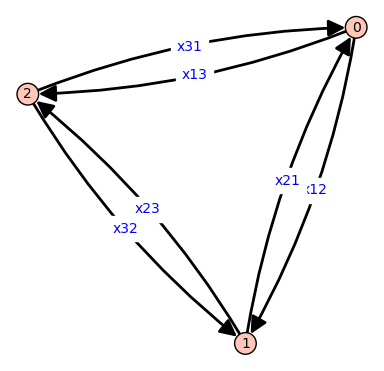

In [4]:
D = create_incidence_matrix(global_n)
DG = DiGraph(D,weighted = True)
DG.show(edge_labels = True)

In [5]:
#here lists are always to be considered as tropical sum of the respective elements of the list, e.g.
# [3,5] --> min(3,5)

def trop_mult(list1,list2):
    # tropical multiplication symbolic lists
    # trop_mult([1,2],[3,4]) = [1+3, 1+4, 2+3, 2+4]
    return list(set([el1 + el2 for el1 in list1 for el2 in list2]))

def trop_sum(list1,list2):
    # tropical sum of symbolic lists
    # trop_sum([1,2],[3,4]) = [1, 2, 3, 4]
    return list(set(list1+list2))


def trop_mat_mult(A_,B_):
    #tropical matrix multiplication of symbolic matrices
    Arows = len(list(A_))
    Acols = len(list(A_[0]))
    Brows = len(list(B_))
    Bcols = len(list(B_[0]))
    P = [[0]*Bcols]*Arows
    A = [ map(lambda x: [x] if not isinstance(x, list) else x, A_[i] ) for i in range(Arows) ]
    B = [ map(lambda x: [x] if not isinstance(x, list) else x, B_[i] ) for i in range(Brows) ]
    P =   [[  list(set(sum([trop_mult(A[i][k],B[k][j]) for k in range(Acols)],[]))) for i in range(Arows)] for j in range(Bcols) ]
    return P

def trop_mat_pwr(D,n):
    #tropical matrix power of symbolic matrices
    D_pwr = D
    for k in range(n-1):
        D_pwr = trop_mat_mult(D_pwr,D)
    return D_pwr

In [6]:
D_star = trop_mat_pwr(D,global_n-1)
show("Here is the Kleene star of of the graph:")
for row in D_star:
    show([" min"+str(tuple(el)) for el in row])

'Here is the Kleene star of of the graph:'

[' min(0, x12 + x21, x13 + x31)',
 ' min(x21, x23 + x31)',
 ' min(x31, x21 + x32)']

[' min(x13 + x32, x12)',
 ' min(x12 + x21, 0, x23 + x32)',
 ' min(x12 + x31, x32)']

[' min(x13, x12 + x23)',
 ' min(x23, x13 + x21)',
 ' min(0, x23 + x32, x13 + x31)']

Creating the regions of the Kleene fan

In [7]:
def create_regions(kleene):
    polyhedral_cplx = []
    for row in kleene:
        for liste in row:
            F = []
            for entry in liste:
                others = copy(liste)
                others.remove(entry)
                R = Polyhedron(ieqs = [ symbols_to_vector(entry) - symbols_to_vector(other) for other in others ])
                F.append(R)
            polyhedral_cplx.append(F)
    #nonneg = [ Polyhedron(ieqs = [[0]*(i+1)+[1]+[0]*(length - (i+1))])  for i in range(length) ]
    return polyhedral_cplx

Find the feasible, full dimensional regions:

In [8]:
def regions_of_complex(polyhedral_complex):
    r"""
    Returns the feasible regions of the ``polyhedral_complex``.
    Follows the method of regions in the hyperplane arrangements.
    
    INPUT: 
    
    - ``polyhedral_complex`` -- list. A list of polyhedron objects
    
    OUTPUT:
    
    A tuple of regions.
    """
    length = len(polyhedral_complex[0][0].vertices()[0])
    R = polyhedral_complex[0][0].base_ring()
    universe = Polyhedron(eqns = [[0] + [0]*length],base_ring = R)
    regions = [universe]
    for fan in polyhedral_complex:
        subdivided = []
        for region in regions:
            for cone in fan:
                part = region.intersection(cone)
                if part.dim()==length:
                    subdivided.append(part)
        regions = subdivided
    return tuple(regions)

Test it on the fans

In [9]:
six_variables_complex = create_regions(D_star)
len(six_variables_complex)

9

In [10]:
regions = regions_of_complex(six_variables_complex)

In [11]:
len(regions)

117

Discard the infeasible regions

In [12]:
def feasible_regions(initial_regions,D_star):
    r"""
    From the regions of a polyhedral complex, return the feasible regions.
    
    INPUT:
    
    -  ``initial_regions`` -- tuple of polyhedron objects. 
    
    OUTPUT:
    
    tuple of polyhedron objects representiing the feasible regions.
    """

    final_regions = list(initial_regions)
    for region in initial_regions:
        ass = region.inequalities_list()
        removed = False
        for index in range(len(D_star)):
            for entry in D_star[index][index]:
                if not entry==0 and not removed:
                    q = Expression(coordinates=symbols_to_vector(entry), assumptions = ass)
                    if q.is_valid_strict():
                        continue
                    else:
                        final_regions.remove(region)
                        removed = True
    return final_regions

In [13]:
feas_regs = feasible_regions(regions,D_star)

In [14]:
len(feas_regs)

18

# Examine the regions

In [15]:
first_region= feas_regs[0]
show("The inequalities for the first region are")
first_region.inequalities_list()

'The inequalities for the first region are'

[[0, -1, 1, 0, 0, 0, 1],
 [0, 0, -1, 0, 1, -1, 1],
 [0, 1, 0, 0, 0, 1, -1],
 [0, 0, 0, 1, -1, -1, 0]]

In [16]:
show("Thus, the inequalities for the corresponding Kleene star are")
for ieq in first_region.inequalities():
    show(Expression(assumptions = first_region.inequalities(), coordinates = ieq).as_symbols()>0)

'Thus, the inequalities for the corresponding Kleene star are'

-x12 + x13 + x32 > 0

-x13 + x23 - x31 + x32 > 0

x12 + x31 - x32 > 0

x21 - x23 - x31 > 0

Computing the corresponding Kleene star:

In [17]:
def minim(liste):
    m = liste[0]
    for el in liste[1:]:
        m = minimum(m,el)
    return m

In [18]:
def kleene_star(region,D_star):
    ass = region.inequalities_list()
    K = [[minim(map(lambda x: Expression(assumptions = ass, coordinates = symbols_to_vector(x)), entry)).as_symbols() for entry in row] for row in D_star ]
    return matrix(K)

In [19]:
show("The above inequalities imply the following Kleene star")
show(kleene_star(first_region,D_star))

'The above inequalities imply the following Kleene star'

[        0 x23 + x31       x31]
[      x12         0       x32]
[      x13       x23         0]

# Compute Polytropes

In [20]:
def tropical_vertices_from_region(region, D_star):
    r"""
    Return the symbolic tropical vertices corresponding to 
    a certain region. 
    
    INPUT:
    
    - ``region`` -- a polyhedron object. 
    
    OUTPUT:
    
    A list of the tropical vertices (already in the plane). 
    """

    Kleene = kleene_star(region,D_star)
    L = list()
    for i in range(len(Kleene.rows())):
        new_row = list()
        j = Kleene.row(i)[0]
        for k in range(1,len(Kleene.row(i))):
            new_row.append(Kleene.row(i)[k] - j)
        L.append(new_row)
    return L

In [21]:
verts = tropical_vertices_from_region(first_region,D_star)
show("This Kleene star corresponds to a polytrope with tropical vertices")
show(matrix(verts).transpose())

'This Kleene star corresponds to a polytrope with tropical vertices'

[ x23 + x31       -x12 -x13 + x23]
[       x31 -x12 + x32       -x13]

Given the tropical vertices and the respective set of inequalities, we can now define our polytrope.

In [22]:
ass = first_region.inequalities_list()
poly = polytron(assumptions = ass, vertices = verts)

In [23]:
poly.vertices

[[x23 + x31, x31], [-x12, -x12 + x32], [-x13 + x23, -x13]]

In [24]:
poly.pseudovertices

[[x23 + x31, x31],
 [-x12, -x12 + x32],
 [-x13 + x23, -x13],
 [x31 - x32, x31],
 [-x12, -x13]]

# Do it for all regions.

In our output, we have a lot of redundancy. Even more, all hexagons have the same Kleene star!

In [25]:
for region in feas_regs:
    verts = tropical_vertices_from_region(region,D_star)
    ass = region.inequalities_list()
    poly = polytron(ass, verts)
    pseudo = poly.pseudovertices
    kleene = kleene_star(region,D_star) 
    print("number of pseudovertices: "+str(len(pseudo)))
    print("Kleene star: ")
    show(kleene)

number of pseudovertices: 5
Kleene star: 


[        0 x23 + x31       x31]
[      x12         0       x32]
[      x13       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0 x23 + x31       x31]
[      x12         0       x32]
[      x13       x23         0]

number of pseudovertices: 6
Kleene star: 


[  0 x21 x31]
[x12   0 x32]
[x13 x23   0]

number of pseudovertices: 6
Kleene star: 


[  0 x21 x31]
[x12   0 x32]
[x13 x23   0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[      x12         0       x32]
[      x13 x13 + x21         0]

number of pseudovertices: 6
Kleene star: 


[  0 x21 x31]
[x12   0 x32]
[x13 x23   0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[      x12         0 x12 + x31]
[      x13       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[x13 + x32         0       x32]
[      x13       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[x13 + x32         0       x32]
[      x13       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0       x21 x21 + x32]
[      x12         0       x32]
[      x13       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0       x21 x21 + x32]
[      x12         0       x32]
[      x13       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[      x12         0       x32]
[x12 + x23       x23         0]

number of pseudovertices: 6
Kleene star: 


[  0 x21 x31]
[x12   0 x32]
[x13 x23   0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[      x12         0       x32]
[x12 + x23       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[      x12         0       x32]
[      x13 x13 + x21         0]

number of pseudovertices: 6
Kleene star: 


[  0 x21 x31]
[x12   0 x32]
[x13 x23   0]

number of pseudovertices: 6
Kleene star: 


[  0 x21 x31]
[x12   0 x32]
[x13 x23   0]

number of pseudovertices: 5
Kleene star: 


[        0       x21       x31]
[      x12         0 x12 + x31]
[      x13       x23         0]

# Group the regions by symmetry

We now group the regions according to their orbit under the action of $S_n$

In [26]:
def mat_eq(m1,m2,perm):
    #returns whether matrices m1, m2 are the same under permutation of indices    
    indices = [(i,j) for i in range(global_n) for j in range(global_n)]
    for i,j in indices:
        if not m1[i][j] == m2[perm[i]][perm[j]]:
            return false
    return true


print mat_eq([[0, 12, 13], [21, 0, 23], [31, 32, 0]], [[0, 21, 23], [12, 0, 13], [32, 31, 0]], [1,0,2])

True


In [27]:
def vec_to_mat(vec):
    #converts vector of length n^2-n into nxn-matrix with zeros on the diagonal
    mat = []
    vec = vec[1:]
    for k in range(global_n):
        row = [el for el in vec[k*(global_n-1) : (k+1)*(global_n-1)]]
        row.insert(k,0)
        mat.append(row)
    return mat

In [28]:
def list_of_mat_eq(l1, l2, perm):
    #returns whether 2 sets of matrices are the same under permutation of indices
    if not len(l1)==len(l2):
        return false
    
    for p in Permutations(range(len(l1))):
        hope = True
        for i in range(len(l1)):
            if not mat_eq(l1[i],l2[p[i]],perm):
                hope = False
                break
        if hope:
            return true
    return false

l1 = [[0, -1, 1, 0, 0, 0, 1], [0, 0, 0, -1, 1, 1, 0], [0, 0, 1, 0, -1, 1, -1], [0, 1, -1, 1, 0, -1, 0]]
l2 = [[0, -1, 1, 0, 0, 0, 1], [0, 0, -1, 0, 1, -1, 1], [0, 0, 0, -1, 1, 1, 0], [0, 1, 0, 1, -1, 0, -1]]
list_of_mat_eq([vec_to_mat(el) for el in l1],[vec_to_mat(el) for el in l2],[1,0,2])

True

In [29]:
def regions_eq(P1,P2):
    #returns whether two regions are the same under permutation of indices
    ieqs1 = [vec_to_mat(vec) for vec in P1.inequalities_list()]
    ieqs2 = [vec_to_mat(vec) for vec in P2.inequalities_list()]
    
    if not len(P1.inequalities_list())==len(P2.inequalities_list()):
        return false
    
    for p in Permutations(range(global_n)): #permutation of indices
        if list_of_mat_eq(ieqs1, ieqs2, p):
            return true
    return false

regions_eq(feas_regs[12],feas_regs[13])

False

In [30]:
def group_by_symmetry(feas_regs):
    groups = [[feas_regs[0]]]
    for region in feas_regs[1:]:
        new_group = True
        for group in groups:
            if regions_eq(region,group[0]):
                group.append(region)
                new_group = False
                break
        if new_group:
            groups.append([region])
    return groups

In [31]:
representatives = [group[0] for group in group_by_symmetry(feas_regs)]
len(representatives)

3

# Let's look at the remaining regions again

In [32]:
for region in representatives:
    verts = tropical_vertices_from_region(region,D_star)
    ass = region.inequalities_list()
    poly = polytron(ass, verts)
    pseudo = poly.pseudovertices
    kleene = kleene_star(region,D_star) 
    print("number of pseudovertices: "+str(len(pseudo)))
    print("Kleene star: ")
    show(kleene)

number of pseudovertices: 5
Kleene star: 


[        0 x23 + x31       x31]
[      x12         0       x32]
[      x13       x23         0]

number of pseudovertices: 5
Kleene star: 


[        0 x23 + x31       x31]
[      x12         0       x32]
[      x13       x23         0]

number of pseudovertices: 6
Kleene star: 


[  0 x21 x31]
[x12   0 x32]
[x13 x23   0]

# Generating function and Ehrhart Polynomial

We compute the generating function using Brion's Theorem

In [33]:
def gen_fct(polytron):
    return sum([tangent_cone(polytron,vertex_index) for vertex_index in range(len(polytron.pseudovertices))])

In [34]:
generating_f = gen_fct(poly).factor()
generating_f

-(t1^(n*x12 + n*x13 + n*x21 + n*x32 + 2)*t2^(n*x12 + n*x13 + n*x21 + 1) - t1^(n*x12 + n*x13 + n*x21 + n*x32 + 1)*t2^(n*x12 + n*x13 + n*x21 + 1) - t1^(n*x12 + n*x13 + n*x21 + n*x32 + 2)*t2^(n*x12 + n*x13 + n*x23 + n*x31 + 2) + t1^(n*x12 + n*x13 + n*x31 + 1)*t2^(n*x12 + n*x13 + n*x23 + n*x31 + 2) + t1^(n*x12 + n*x13 + n*x21 + n*x32 + 1)*t2^(n*x12 + n*x13 + n*x23 + n*x31 + 1) - t1^(n*x12 + n*x13 + n*x31 + 1)*t2^(n*x12 + n*x13 + n*x23 + n*x31 + 1) + t1^(n*x12 + n*x23 + n*x32 + 1)*t2^(n*x12 + n*x23 + 1) - t1^(n*x13 + n*x32 + 1)*t2^(n*x12 + n*x23 + 1) - t1^(n*x12 + n*x23 + n*x32 + 1)*t2^(n*x12 + n*x23) + t1^(n*x13 + n*x32)*t2^(n*x12 + n*x23) + t1^(n*x13 + n*x32 + 1)*t2^(n*x13 + n*x23 + n*x32 + 1) - t1^(n*x13 + n*x32)*t2^(n*x13 + n*x23 + n*x32 + 1))*t1^(-n*x12 - n*x13 - n*x32)*t2^(-n*x12 - n*x13 - n*x23)/((t1*t2 - 1)*(t1 - 1)*(t2 - 1))

We can get the Ehrhart Pplynomial by evaluating the generating function at $(1,\dots,1)$. But since this would mean division by zero in this case, we first have to replace all variables by $(1-t)$ apply l'hopital.

In [35]:
def lhopital(generating_f):
    #substitute all variables by (1-t)
    t = var('t')
    for j in range(1,3):
         generating_f = generating_f.subs({var('t'+str(j)):1-t})
        #generating_f = generating_f.subs({var('t'+str(j)):1-j*t})
    
    #l'hopital
    p = generating_f.numerator()
    q = generating_f.denominator()
    alpha = 0
    p_deriv= p
    q_deriv = q
    while true:
        p_deriv = p_deriv.derivative(t)
        q_deriv = q_deriv.derivative(t)
        alpha += 1
        if not (p_deriv(t=0)==0 or q_deriv(t=0)==0):
            break
    return p_deriv(t=0)/q_deriv(t=0)

In [36]:
ehrhart = lhopital(generating_f).simplify_full()
ehrhart

-1/2*n^2*x12^2 - 1/2*n^2*x13^2 - 1/2*n^2*x21^2 - 1/2*n^2*x23^2 - 1/2*n^2*x31^2 - 1/2*n^2*x32^2 + 1/2*n*x12 + 1/2*(2*n^2*x12 + n)*x13 + 1/2*n*x21 + 1/2*(2*n^2*x13 + 2*n^2*x21 + n)*x23 + 1/2*(2*n^2*x21 + n)*x31 + 1/2*(2*n^2*x12 + 2*n^2*x31 + n)*x32 + 1

# Do it for all regions once more

Computing the generating function for all feasible regions

In [37]:
generating_fcts = {}
count = -1
for region in representatives:
    verts = tropical_vertices_from_region(region,D_star)
    ass = region.inequalities_list()
    poly = polytron(ass, verts)
    pseudo = poly.pseudovertices
    count += 1
    try:
        generating_f = gen_fct(poly).factor()
        generating_fcts[generating_f] = ass
    except:
        print 'impossible to compute generating function for region '+str(count)
        continue

In [38]:
multivariate_ehrhart = {}
for generating_f, ieqs in generating_fcts.items():
    ehr = lhopital(generating_f).simplify_full()
    multivariate_ehrhart[ehr] = ieqs

In [39]:
for ehr, ieqs in multivariate_ehrhart.items():
    print ehr
    conditions = [vector_to_symbols(ieq)>0 for ieq in ieqs]
    print "   if "+str(conditions).strip('[]')
    print ""

-1/2*n^2*x12^2 - 1/2*n^2*x13^2 - 1/2*n^2*x21^2 - 1/2*n^2*x23^2 - 1/2*n^2*x31^2 - 1/2*n^2*x32^2 + 1/2*n*x12 + 1/2*(2*n^2*x12 + n)*x13 + 1/2*n*x21 + 1/2*(2*n^2*x13 + 2*n^2*x21 + n)*x23 + 1/2*(2*n^2*x21 + n)*x31 + 1/2*(2*n^2*x12 + 2*n^2*x31 + n)*x32 + 1
   if -x12 + x13 + x32 > 0, -x13 + x23 - x31 + x32 > 0, -x21 + x23 + x31 > 0, x12 + x21 - x23 - x32 > 0

-1/2*n^2*x12^2 - 1/2*n^2*x13^2 - 1/2*n^2*x32^2 + 1/2*n*x12 + 1/2*(2*n^2*x12 + n)*x13 + (n^2*x13 + n)*x23 + (n^2*x23 + n)*x31 + 1/2*(2*n^2*x12 + 2*n^2*x31 + n)*x32 + 1
   if -x12 + x13 + x32 > 0, x21 - x23 - x31 > 0, x13 - x23 + x31 - x32 > 0, x12 - x13 + x23 > 0

